In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel

# Load Dataset
data_path = '/content/drive/MyDrive/ML-shit/labeled_data.csv'
data = pd.read_csv(data_path)

# Data Preprocessing
data['cleaned_text'] = data['tweet'].apply(lambda x: x.lower().strip())
labels = data['class'].values

# Tokenizer and GloVe Embeddings
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def load_glove_embeddings(file_path, embedding_dim):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs
    return embeddings_index

# Load GloVe Embeddings (example for 100d)
glove_path = '/content/drive/MyDrive/ML-shit/glove.6B.100d.txt'
embedding_dim = 100
embeddings_index = load_glove_embeddings(glove_path, embedding_dim)

# Prepare Embedding Matrix
vocab = bert_tokenizer.get_vocab()  # Use get_vocab to get token IDs
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector

# Tokenization
def tokenize_texts(texts, tokenizer, max_len=128):
    encoded = tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='np'
    )
    return encoded['input_ids'], encoded['attention_mask']

input_ids, attention_mask = tokenize_texts(data['cleaned_text'], bert_tokenizer)

# Model Architecture
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Inputs
input_ids_layer = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# BERT Embeddings
bert_output = tf.keras.layers.Lambda(
    lambda x: bert_model(x[0], attention_mask=tf.cast(x[1], dtype=tf.int32)).last_hidden_state,
    output_shape=(128, 768)  # Specify the output shape here
)([input_ids_layer, attention_mask_layer])

# Static Embeddings (GloVe)
static_embedding_layer = Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=128,
    trainable=False
)(input_ids_layer)

# Concatenate BERT + GloVe
concatenated = Concatenate()([bert_output, static_embedding_layer])

# BiLSTM Layer
bi_lstm = Bidirectional(LSTM(128, return_sequences=False))(concatenated)

# Dense Layers
x = Dropout(0.3)(bi_lstm)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    [input_ids, attention_mask],
    labels,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Save the Model
model.save('bilstm_bert_glove_model-1.h5')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 224s 309ms/step - accuracy: 0.8360 - loss: 0.4701 - val_accuracy: 0.9100 - val_loss: 0.2560
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 262s 309ms/step - accuracy: 0.9064 - loss: 0.2678 - val_accuracy: 0.9169 - val_loss: 0.2428
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 217s 311ms/step - accuracy: 0.9127 - loss: 0.2415 - val_accuracy: 0.9205 - val_loss: 0.2275
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 279s 336ms/step - accuracy: 0.9190 - loss: 0.2199 - val_accuracy: 0.9165 - val_loss: 0.2398
Epoch 5/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 262s 337ms/step - accuracy: 0.9278 - loss: 0.1926 - val_accuracy: 0.9088 - val_loss: 0.2607
Epoch 6/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 236s 339ms/step - accuracy: 0.9339 - loss: 0.1737 - val_accuracy: 0.9149 - val_loss: 0.2638


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel

# Load Dataset
data_path = '/content/drive/MyDrive/ML-shit/labeled_data.csv'
data = pd.read_csv(data_path)

# Data Preprocessing
data['cleaned_text'] = data['tweet'].apply(lambda x: x.lower().strip())
labels = data['class'].values

# Tokenizer and GloVe Embeddings
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def load_glove_embeddings(file_path, embedding_dim):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs
    return embeddings_index

# Load GloVe Embeddings (example for 100d)
glove_path = '/content/drive/MyDrive/ML-shit/glove.6B.100d.txt'
embedding_dim = 100
embeddings_index = load_glove_embeddings(glove_path, embedding_dim)

# Prepare Embedding Matrix
vocab = bert_tokenizer.vocab
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector

# Tokenization
def tokenize_texts(texts, tokenizer, max_len=128):
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors='np')
    return encoded['input_ids'], encoded['attention_mask']


input_ids, attention_mask = tokenize_texts(data['cleaned_text'].tolist(), bert_tokenizer)

# Model Architecture
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Inputs
input_ids_layer = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask_layer = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

# BERT Embeddings
# BERT Embeddings
# Wrap the bert_model call in a Lambda layer to convert KerasTensors to TensorFlow Tensors
# BERT Embeddings
bert_output = tf.keras.layers.Lambda(
    lambda x: bert_model(x[0], attention_mask=tf.cast(x[1], dtype=tf.int32)).last_hidden_state,
    output_shape=(128, 768)  # Set output shape based on BERT's output shape
)([input_ids_layer, attention_mask_layer])


# Static Embeddings (GloVe)
static_embedding_layer = Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=128,
    trainable=False
)(input_ids_layer)

# Concatenate BERT + GloVe
concatenated = Concatenate()([bert_output, static_embedding_layer])

# BiLSTM Layer
bi_lstm = Bidirectional(LSTM(128, return_sequences=False))(concatenated)

# Dense Layers
x = Dropout(0.3)(bi_lstm)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# Model
model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(
    [input_ids, attention_mask],
    labels,
    validation_split=0.1,
    epochs=3,
    batch_size=32
)

# Save the Model
model.save('bilstm_bert_glove_model-2.h5')

# Test Function
def test_model(test_texts, model_path):
    # Load the trained model
    model = tf.keras.models.load_model(model_path, custom_objects={'TFBertModel': TFBertModel})

    # Tokenize the test texts
    test_input_ids, test_attention_mask = tokenize_texts(test_texts, bert_tokenizer)

    # Predict
    predictions = model.predict([test_input_ids, test_attention_mask])
    predicted_classes = np.argmax(predictions, axis=1)

    return predicted_classes

# Example Usage
test_texts = [
    "fucking bitch, get into the kitchen. that's where you belong",
    "i will go to college tomorrow and see my cute crush",
    "these Whites always think they are fucking superior than Blacks",
    "fuck you nigga, you don't belong here",
    "You are so stupid!"
]
predicted_classes = test_model(test_texts, 'bilstm_bert_glove_model-2.h5')
print("Predicted Classes:", predicted_classes)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 221s 305ms/step - accuracy: 0.8340 - loss: 0.4798 - val_accuracy: 0.9092 - val_loss: 0.2641
Epoch 2/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 262s 306ms/step - accuracy: 0.9056 - loss: 0.2736 - val_accuracy: 0.9189 - val_loss: 0.2364
Epoch 3/3
697/697 ━━━━━━━━━━━━━━━━━━━━ 263s 308ms/step - accuracy: 0.9170 - loss: 0.2397 - val_accuracy: 0.9181 - val_loss: 0.2346


ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 128), found shape=(5, 16)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer

# Custom function to load your trained model
def load_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

# Use the same tokenizer that was used during training (If you used BERT-based tokenization during training)
# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Test texts
test_texts = [
    "fucking bitch, get into the kitchen. that's where you belong",
    "i will go to college tomorrow and see my cute crush",
    "these Whites always think they are fucking superior than Blacks",
    "fuck you nigga, you don't belong here",
    "You are so stupid!"
]

# Tokenize the input text using BERT's tokenizer
def tokenize_texts(texts, tokenizer, max_len=128):
    # Use BERT tokenizer to tokenize and pad the texts
    encoded = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors='np')
    return encoded['input_ids'], encoded['attention_mask']

# Test model
def test_model(test_texts, model, tokenizer):
    # Tokenize the text using BERT tokenizer
    input_ids, attention_mask = tokenize_texts(test_texts, tokenizer)

    # Convert to TensorFlow format
    input_data = {
        'input_ids': tf.convert_to_tensor(input_ids),
        'attention_mask': tf.convert_to_tensor(attention_mask)
    }

    # Get predictions from the model
    predictions = model.predict(input_data)

    # Get the predicted class (assuming it's a classification problem with 3 classes)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes

# Load the trained model
model = load_model('bilstm_bert_glove_model-2.h5')

# Get predictions
predicted_classes = test_model(test_texts, model, tokenizer)
print("Predicted Classes:", predicted_classes)


ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 128), found shape=(5, 16)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

# Step 1: Data Preparation
# Load CIFAR-10 dataset (adapt this to a 5-class dataset as required)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Use a subset of CIFAR-10 to simulate a 5-class problem
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use only 5 classes (for example, classes 0, 1, 2, 3, 4)
class_subset = [0, 1, 2, 3, 4]
trainset.targets = [trainset.targets[i] for i in range(len(trainset.targets)) if trainset.targets[i] in class_subset]
testset.targets = [testset.targets[i] for i in range(len(testset.targets)) if testset.targets[i] in class_subset]
trainset.data = trainset.data[[i for i in range(len(trainset.targets)) if trainset.targets[i] in class_subset]]
testset.data = testset.data[[i for i in range(len(testset.targets)) if testset.targets[i] in class_subset]]

# DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Step 2: Define the CNN Architectures

# LeNet-5 Architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)  # 5 classes for classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # Flatten the input for fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# VGG-16 Architecture
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        # Modify the classifier to accept the correct input size
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Adjusted input size
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 5)  # 5 classes for classification
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.classifier(x)
        return x

# MobileNet Architecture
class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 5)

    def forward(self, x):
        return self.model(x)

# ResNet-18 Architecture
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 5)

    def forward(self, x):
        return self.model(x)

# Step 3: Train and Evaluate the Models
def train_and_evaluate(model, trainloader, testloader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")

    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total}%")

# Step 4: Execute the Training and Evaluation for each model

print("Training LeNet-5")
lenet5 = LeNet5()
train_and_evaluate(lenet5, trainloader, testloader)

print("Training VGG-16")
vgg16 = VGG16()
train_and_evaluate(vgg16, trainloader, testloader)

print("Training MobileNet")
mobilenet = MobileNet()
train_and_evaluate(mobilenet, trainloader, testloader)

print("Training ResNet-18")
resnet18 = ResNet18()
train_and_evaluate(resnet18, trainloader, testloader)


Files already downloaded and verified
Files already downloaded and verified
Training LeNet-5
Epoch 1/10, Loss: 1.6101328064413631
Epoch 2/10, Loss: 1.6099026043091893
Epoch 3/10, Loss: 1.6096878542619593
Epoch 4/10, Loss: 1.6098058182565147
Epoch 5/10, Loss: 1.6097559564558745
Epoch 6/10, Loss: 1.6097240919042426
Epoch 7/10, Loss: 1.609733902279983
Epoch 8/10, Loss: 1.6096729849610487
Epoch 9/10, Loss: 1.6096150702832606
Epoch 10/10, Loss: 1.609723617201266
Test Accuracy: 20.0%
Training VGG-16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 25088x4096)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np

# Data Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-10 Dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter dataset to keep only 5 classes (e.g., classes 0 to 4)
def filter_classes(dataset, classes_to_keep):
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes_to_keep]
    return Subset(dataset, indices)

classes_to_keep = [0, 1, 2, 3, 4]  # Select first 5 classes
trainset = filter_classes(trainset, classes_to_keep)
testset = filter_classes(testset, classes_to_keep)

# Update labels to match the new range (0 to 4)
def update_labels(subset, classes_to_keep):
    label_map = {old: new for new, old in enumerate(classes_to_keep)}
    subset.dataset.targets = [label_map.get(label, label) for _, label in subset.dataset]
    # Use get with a default to handle unseen labels
    return subset

trainset = update_labels(trainset, classes_to_keep)
testset = update_labels(testset, classes_to_keep)

# DataLoader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Define VGG-16 for CIFAR-10
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

        # Adaptive Pooling to ensure the correct output size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))

        # Custom classifier for CIFAR-10 (5 classes)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 5),  # Adjusted for 5 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, -1)
        x = self.classifier(x)
        return x

# Define Training and Evaluation
def train_and_evaluate(model, trainloader, testloader, epochs=5, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Train and Evaluate VGG-16
vgg16 = VGG16()
train_and_evaluate(vgg16, trainloader, testloader)


Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST and Fashion-MNIST datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
testloader_mnist = DataLoader(mnist_test, batch_size=64, shuffle=False)

trainloader_fashion = DataLoader(fashion_mnist_train, batch_size=64, shuffle=True)
testloader_fashion = DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)

# Define Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, layers=2):
        super(Autoencoder, self).__init__()
        encoder_layers = []
        decoder_layers = []

        # Encoder: Dynamically create layers
        input_dim = 28 * 28
        hidden_dim = 128
        for _ in range(layers):
            encoder_layers.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            input_dim = hidden_dim
            hidden_dim //= 2

        # Bottleneck layer
        hidden_dim *= 2
        encoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder: Reverse the process
        for _ in range(layers):
            decoder_layers.append(nn.Linear(hidden_dim, hidden_dim * 2))
            decoder_layers.append(nn.ReLU())
            hidden_dim *= 2

        decoder_layers.append(nn.Linear(hidden_dim, 28 * 28))
        decoder_layers.append(nn.Tanh())  # To match normalized input range (-1, 1)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), 1, 28, 28)

# Evaluation metrics

def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

    psnr_values, ssim_values = [], []
    for orig, recon in zip(original, reconstructed):
        orig = orig[0]  # Single channel
        recon = recon[0]  # Single channel
        psnr_values.append(psnr(orig, recon, data_range=2))  # Data range [-1, 1]
        ssim_values.append(ssim(orig, recon, data_range=2))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Train and evaluate function
def train_and_evaluate_autoencoder(dataloader, testloader, layers=2, epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder(layers=layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader):.4f}")

    # Evaluate
    model.eval()
    psnr_total, ssim_total = 0, 0
    with torch.no_grad():
        for inputs, _ in testloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            batch_psnr, batch_ssim = calculate_metrics(inputs, outputs)
            psnr_total += batch_psnr
            ssim_total += batch_ssim

    avg_psnr = psnr_total / len(testloader)
    avg_ssim = ssim_total / len(testloader)

    print(f"Reconstruction PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

# Train and evaluate on MNIST
def main():
    print("Training Autoencoder on MNIST")
    train_and_evaluate_autoencoder(trainloader_mnist, testloader_mnist, layers=2)

    print("\nTraining Autoencoder on Fashion-MNIST")
    train_and_evaluate_autoencoder(trainloader_fashion, testloader_fashion, layers=2)

if __name__ == "__main__":
    main()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 520kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.94MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26.4M/26.4M [00:02<00:00, 13.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.83MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 1.25MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training Autoencoder on MNIST
Epoch 1/10, Loss: 0.1276
Epoch 2/10, Loss: 0.0644
Epoch 3/10, Loss: 0.0509
Epoch 4/10, Loss: 0.0436
Epoch 5/10, Loss: 0.0393
Epoch 6/10, Loss: 0.0361
Epoch 7/10, Loss: 0.0334
Epoch 8/10, Loss: 0.0315
Epoch 9/10, Loss: 0.0300
Epoch 10/10, Loss: 0.0287
Reconstruction PSNR: 22.29, SSIM: 0.8946

Training Autoencoder on Fashion-MNIST
Epoch 1/10, Loss: 0.0934
Epoch 2/10, Loss: 0.0575
Epoch 3/10, Loss: 0.0497
Epoch 4/10, Loss: 0.0456
Epoch 5/10, Loss: 0.0429
Epoch 6/10, Loss: 0.0409
Epoch 7/10, Loss: 0.0393
Epoch 8/10, Loss: 0.0381
Epoch 9/10, Loss: 0.0371
Epoch 10/10, Loss: 0.0361
Reconstruction PSNR: 21.38, SSIM: 0.7521


Training Autoencoder on MNIST
Epoch 1/10, Loss: 0.1234, PSNR: 18.33, SSIM: 0.7688
Epoch 2/10, Loss: 0.0600, PSNR: 19.69, SSIM: 0.8235
Epoch 3/10, Loss: 0.0475, PSNR: 20.49, SSIM: 0.8494
Epoch 4/10, Loss: 0.0410, PSNR: 21.04, SSIM: 0.8619
Epoch 5/10, Loss: 0.0367, PSNR: 21.54, SSIM: 0.8780
Epoch 6/10, Loss: 0.0338, PSNR: 21.78, SSIM: 0.8846
Epoch 7/10, Loss: 0.0316, PSNR: 22.01, SSIM: 0.8890
Epoch 8/10, Loss: 0.0299, PSNR: 22.19, SSIM: 0.8937
Epoch 9/10, Loss: 0.0284, PSNR: 22.37, SSIM: 0.8938
Epoch 10/10, Loss: 0.0273, PSNR: 22.35, SSIM: 0.8966


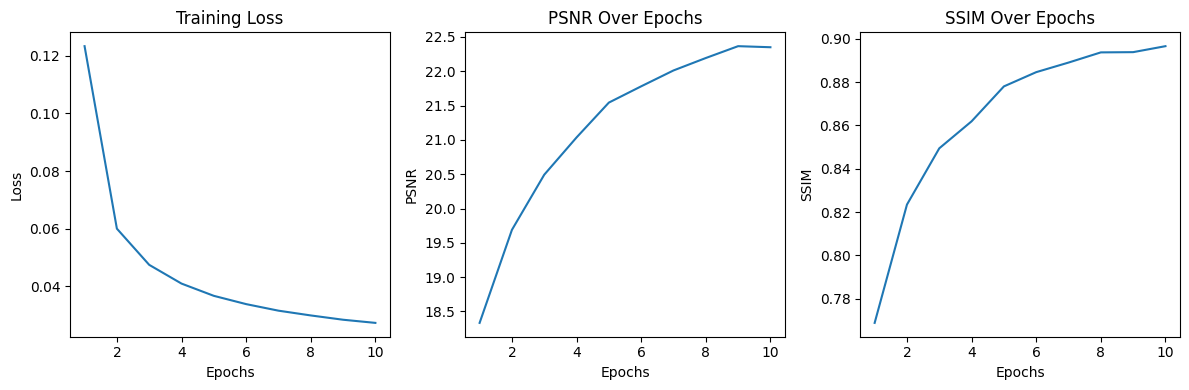


Training Autoencoder on Fashion-MNIST
Epoch 1/10, Loss: 0.0973, PSNR: 18.49, SSIM: 0.6166
Epoch 2/10, Loss: 0.0585, PSNR: 19.46, SSIM: 0.6663
Epoch 3/10, Loss: 0.0507, PSNR: 20.00, SSIM: 0.6922
Epoch 4/10, Loss: 0.0465, PSNR: 20.30, SSIM: 0.7000
Epoch 5/10, Loss: 0.0437, PSNR: 20.44, SSIM: 0.7088
Epoch 6/10, Loss: 0.0417, PSNR: 20.70, SSIM: 0.7215
Epoch 7/10, Loss: 0.0401, PSNR: 20.94, SSIM: 0.7331
Epoch 8/10, Loss: 0.0388, PSNR: 21.07, SSIM: 0.7391
Epoch 9/10, Loss: 0.0377, PSNR: 21.20, SSIM: 0.7415
Epoch 10/10, Loss: 0.0367, PSNR: 21.31, SSIM: 0.7458


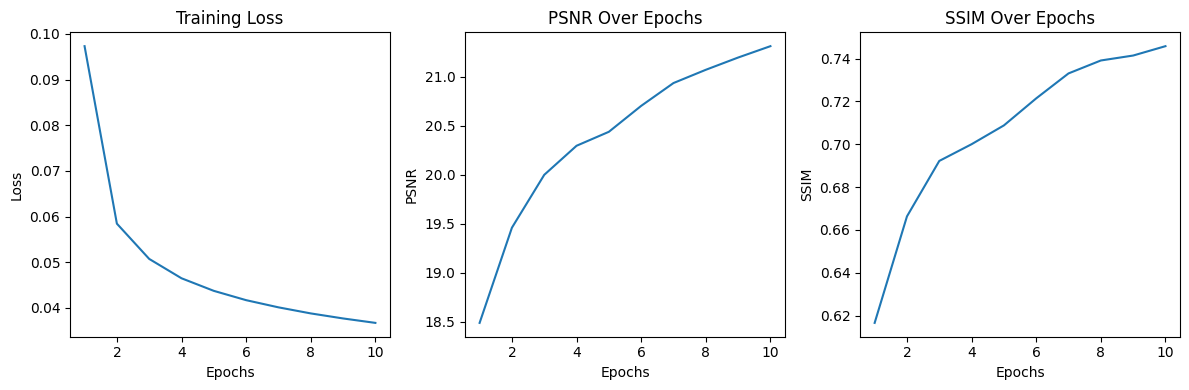

NameError: name 'device' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST and Fashion-MNIST datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_mnist_train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader_mnist = DataLoader(mnist_train, batch_size=64, shuffle=True)
testloader_mnist = DataLoader(mnist_test, batch_size=64, shuffle=False)

trainloader_fashion = DataLoader(fashion_mnist_train, batch_size=64, shuffle=True)
testloader_fashion = DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)

# Define Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, layers=2):
        super(Autoencoder, self).__init__()
        encoder_layers = []
        decoder_layers = []

        # Encoder: Dynamically create layers
        input_dim = 28 * 28
        hidden_dim = 128
        for _ in range(layers):
            encoder_layers.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers.append(nn.ReLU())
            input_dim = hidden_dim
            hidden_dim //= 2

        # Bottleneck layer
        hidden_dim *= 2
        encoder_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder: Reverse the process
        for _ in range(layers):
            decoder_layers.append(nn.Linear(hidden_dim, hidden_dim * 2))
            decoder_layers.append(nn.ReLU())
            hidden_dim *= 2

        decoder_layers.append(nn.Linear(hidden_dim, 28 * 28))
        decoder_layers.append(nn.Tanh())  # To match normalized input range (-1, 1)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), 1, 28, 28)

# Evaluation metrics
def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()

    psnr_values, ssim_values = [], []
    for orig, recon in zip(original, reconstructed):
        orig = orig[0]  # Single channel
        recon = recon[0]  # Single channel
        psnr_values.append(psnr(orig, recon, data_range=2))  # Data range [-1, 1]
        ssim_values.append(ssim(orig, recon, data_range=2))

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Train and evaluate function
def train_and_evaluate_autoencoder(dataloader, testloader, layers=2, epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Autoencoder(layers=layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    psnr_scores = []
    ssim_scores = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(dataloader))

        # Evaluate after each epoch
        model.eval()
        psnr_total, ssim_total = 0, 0
        with torch.no_grad():
            for inputs, _ in testloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                batch_psnr, batch_ssim = calculate_metrics(inputs, outputs)
                psnr_total += batch_psnr
                ssim_total += batch_ssim

        avg_psnr = psnr_total / len(testloader)
        avg_ssim = ssim_total / len(testloader)
        psnr_scores.append(avg_psnr)
        ssim_scores.append(avg_ssim)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_losses[-1]:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    # Plotting training loss, PSNR, and SSIM
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")

    # Plot PSNR
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), psnr_scores, label="PSNR")
    plt.xlabel("Epochs")
    plt.ylabel("PSNR")
    plt.title("PSNR Over Epochs")

    # Plot SSIM
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), ssim_scores, label="SSIM")
    plt.xlabel("Epochs")
    plt.ylabel("SSIM")
    plt.title("SSIM Over Epochs")

    plt.tight_layout()
    plt.show()

    return model

# Train and evaluate on MNIST
def main():
    print("Training Autoencoder on MNIST")
    model_mnist = train_and_evaluate_autoencoder(trainloader_mnist, testloader_mnist, layers=2)

    print("\nTraining Autoencoder on Fashion-MNIST")
    model_fashion_mnist = train_and_evaluate_autoencoder(trainloader_fashion, testloader_fashion, layers=2)

    # Display some reconstructed images for visual inspection
    model_mnist.eval()
    model_fashion_mnist.eval()
    with torch.no_grad():
        # Get a batch of test images
        inputs_mnist, _ = next(iter(testloader_mnist))
        inputs_fashion, _ = next(iter(testloader_fashion))

        # Send them to the device
        inputs_mnist = inputs_mnist.to(device)
        inputs_fashion = inputs_fashion.to(device)

        # Get the reconstructed outputs
        outputs_mnist = model_mnist(inputs_mnist)
        outputs_fashion = model_fashion_mnist(inputs_fashion)

        # Plot original vs reconstructed images
        def plot_reconstruction(inputs, outputs, dataset_name="Dataset"):
            fig, ax = plt.subplots(2, 8, figsize=(12, 4))
            for i in range(8):
                ax[0, i].imshow(inputs[i].cpu().numpy().squeeze(), cmap='gray')
                ax[0, i].set_title(f"{dataset_name} Original")
                ax[0, i].axis('off')
                ax[1, i].imshow(outputs[i].cpu().numpy().squeeze(), cmap='gray')
                ax[1, i].set_title(f"{dataset_name} Reconstructed")
                ax[1, i].axis('off')
            plt.tight_layout()
            plt.show()

        plot_reconstruction(inputs_mnist, outputs_mnist, "MNIST")
        plot_reconstruction(inputs_fashion, outputs_fashion, "Fashion-MNIST")

if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter dataset for the first 5 classes (0-4)
filtered_indices_train = [i for i, target in enumerate(train_data.targets) if target < 5]
filtered_indices_test = [i for i, target in enumerate(test_data.targets) if target < 5]

train_data = Subset(train_data, filtered_indices_train)
test_data = Subset(test_data, filtered_indices_test)

# Update labels to range 0-4
for i in range(len(train_data)):
    train_data.dataset.targets[train_data.indices[i]] %= 5
for i in range(len(test_data)):
    test_data.dataset.targets[test_data.indices[i]] %= 5

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# VGG-16 Architecture
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.model = models.vgg16(weights=None)  # Load VGG16 without pretrained weights
        self.model.classifier[6] = nn.Linear(4096, num_classes)  # Adjust output layer

    def forward(self, x):
        return self.model(x)

# Training and Evaluation Functions
def train_and_evaluate(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Test Accuracy: {accuracy:.2f}%")

    # Plot Loss and Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Initialize and Train Model
model = VGG16(num_classes=5)
train_and_evaluate(model, train_loader, test_loader, epochs=10, learning_rate=0.001)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 1.6199
Test Accuracy: 20.00%
Epoch 2/20, Loss: 1.6097
Test Accuracy: 20.00%
Epoch 3/20, Loss: 1.6096
Test Accuracy: 20.00%
Epoch 4/20, Loss: 1.6096
Test Accuracy: 20.00%
Epoch 5/20, Loss: 1.6096
Test Accuracy: 20.00%


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout

# Load dataset
data = pd.read_csv('/content/labeled_data.csv')  # Replace with the actual CSV file name

# Extract text and labels
tweets = data['tweet'].astype(str).tolist()
labels = data['class'].values

# Tokenization and padding
max_words = 20000  # Maximum number of words to tokenize
max_len = 50  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(tweets)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare GloVe embeddings
glove_file = '/content/drive/MyDrive/ML-shit/glove.6B.100d.txt'  # Replace with your GloVe file path
embedding_dim = 100
embedding_index = {}

with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Build BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Test on example sentences
test_texts = [
    "all women must be killed",
    "i will go to college tomorrow and see my cute crush",
    "i did shit on my exam, i failed",
    "fucking nigger go back",
    "You are so stupid!"
]

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to labels
label_map = {0: "Hate Speech", 1: "Offensive Speech", 2: "Neutral"}
for text, label in zip(test_texts, predicted_classes):
    print(f"Text: {text}\nPredicted Class: {label_map[label]}\n")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8038 - loss: 0.5918 - val_accuracy: 0.8822 - val_loss: 0.3262
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8765 - loss: 0.3528 - val_accuracy: 0.8901 - val_loss: 0.2978
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8787 - loss: 0.3164 - val_accuracy: 0.8956 - val_loss: 0.2998
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8884 - loss: 0.2987 - val_accuracy: 0.9029 - val_loss: 0.2728
Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8967 - loss: 0.2748 - val_accuracy: 0.9062 - val_loss: 0.2701
Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9048 - loss: 0.2545 - val_accuracy: 0.9022 - val_loss: 0.2721
Epoch 7/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9107 - loss: 0.2447 - val_accuracy: 0.9100 - val_loss: 0.2854
Epoch 8/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9152 - loss: 0.2274 - val_accurac

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv('/content/modified_dataset_1.csv')  # Replace with the actual CSV file name

# Extract text and labels
tweets = data['cleaned_tweet'].astype(str).tolist()

# Update class values for labels: abusive, neutral, racism, sexism
# Assuming classes are in the range 1-4 (1-abusive, 2-neutral, 3-racism, 4-sexism)
labels = data['class'].values - 1  # Convert labels from [1, 4] to [0, 3] for compatibility

# One-hot encode the labels (if using categorical crossentropy)
labels = to_categorical(labels, num_classes=4)

# Tokenization and padding
max_words = 20000  # Maximum number of words to tokenize
max_len = 50  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(tweets)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare GloVe embeddings
glove_file = '/content/drive/MyDrive/ML-shit/glove.6B.200d.txt'  # Replace with your GloVe file path
embedding_dim = 200
embedding_index = {}

with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Build BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output units for 4 classes
])

# Compile model with lower learning rate and gradient clipping
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)  # Lower learning rate and gradient clipping
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical_crossentropy for one-hot encoding
model.summary()

# Train the model
epochs = 25
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Test on example sentences
test_texts = [
    "all women must be killed",
    "i will go to college tomorrow and see my cute crush",
    "i did shit on my exam, i failed",
    "fucking nigger go back",
    "You are so stupid!"
]

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to labels
label_map = {0: "Abusive", 1: "Neutral", 2: "Racism", 3: "Sexism"}
for text, label in zip(test_texts, predicted_classes):
    print(f"Text: {text}\nPredicted Class: {label_map[label]}\n")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │       4,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,000,000 (15.26 MB)

 Trainable params: 4,000,000 (15.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3738 - loss: 1.2557 - val_accuracy: 0.5391 - val_loss: 1.0048
Epoch 2/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5093 - loss: 1.0068 - val_accuracy: 0.6251 - val_loss: 0.8680
Epoch 3/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5827 - loss: 0.9076 - val_accuracy: 0.6473 - val_loss: 0.8112
Epoch 4/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6140 - loss: 0.8531 - val_accuracy: 0.6576 - val_loss: 0.7728
Epoch 5/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6429 - loss: 0.7955 - val_accuracy: 0.6720 - val_loss: 0.7497
Epoch 6/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.6724 - loss: 0.7476 - val_accuracy: 0.6795 - val_loss: 0.7294
Epoch 7/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6922 - loss: 0.7016 - val_accuracy: 0.6831 - val_loss: 0.7288
Epoch 8/25
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7142 - loss: 0.6732 - val

In [ ]:
import pandas as pd
import re

# Load the dataset (replace 'your_dataset.csv' with the actual CSV file path)
data = pd.read_csv('/content/cleaned_tweets.csv')

# Define a function to remove special characters and numbers from the tweet
def remove_special_characters_and_numbers(text):
    # Remove all non-alphabetic characters (including numbers)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Strip any leading or trailing whitespaces
    text = text.strip()
    return text

# Apply the function to the 'tweet' column
data['cleaned_tweet'] = data['tweet'].apply(remove_special_characters_and_numbers)

# Save the cleaned data to a new CSV file, retaining all other columns
data.to_csv('cleaned_tweets_no_special_characters.csv', index=False)

# Display the first few rows to check
print(data.head())


In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/modified_dataset_with_serial_no.csv')

# Load the Hugging Face pipeline for zero-shot classification
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define labels for classification
labels = ["racism", "sexism", "abusive"]

# Function to classify tweets
def classify_tweet_hf(tweet, current_class):
    if current_class != 0:  # Only process tweets with class 1 (abusive)
        return current_class

    try:
        # Classify the tweet
        result = classifier(tweet, labels)
        # Find the label with the highest score
        top_label = result['labels'][0]

        # Map the top label to class numbers
        if top_label == "racism":
            return 3
        elif top_label == "sexism":
            return 4
        else:
            return current_class  # Retain class 1 if not racism or sexism
    except Exception as e:
        print(f"Error processing tweet: {tweet}\nError: {e}")
        return current_class  # Retain the original class in case of errors

# Apply the classification function to only the 'cleaned_tweet' and 'class' columns
data['class'] = data.apply(
    lambda row: classify_tweet_hf(row['cleaned_tweet'], row['class']), axis=1
)

# Retain only 'Serial_No', 'cleaned_tweet', and 'class' columns for the output
output_data = data[['Serial_No', 'cleaned_tweet', 'class']]

# Save the modified dataset to a new CSV file
output_data.to_csv('modified_dataset_1.csv', index=False)

# Display the first few rows of the modified dataset
print(output_data.head())


Device set to use cuda:0


   Serial_No                                      cleaned_tweet  class
0          1  As a woman you shouldnt complain about cleanin...      2
1          2  boy dats coldtyga dwn bad for cuffin dat hoe i...      1
2          3  RT  Dawg You ever fuck a bitch and she start t...      1
3          4                             she look like a tranny      4
4          5  The shit you hear about me might be true or it...      1


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/modified_dataset_1.csv')  # Replace with the actual path to your CSV file

# Change all '0' values in the 'class' column to '1'
data['class'] = data['class'].replace(0, 1)

# Save the modified dataset to a new CSV file
data.to_csv('modified_class_column.csv', index=False)

# Display the first few rows of the modified dataset
print(data.head())


   Serial_No                                      cleaned_tweet  class
0          1  As a woman you shouldnt complain about cleanin...      2
1          2  boy dats coldtyga dwn bad for cuffin dat hoe i...      1
2          3  RT  Dawg You ever fuck a bitch and she start t...      1
3          4                             she look like a tranny      4
4          5  The shit you hear about me might be true or it...      1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/modified_data-1.csv')  # Replace with the actual file path

# List of keywords to check for in the 'cleaned_tweet' column
keywords = ['nigga', 'nigger', 'niggas', 'blacks', 'whites', 'nigs']  # Replace with your actual keywords

# Convert the 'cleaned_tweet' column to lowercase to handle case insensitivity
data['cleaned_tweet'] = data['cleaned_tweet'].str.lower()

# Create a mask where 'cleaned_tweet' contains any of the keywords and 'class' is 1
mask = data['cleaned_tweet'].apply(lambda x: any(keyword in str(x) for keyword in keywords)) & (data['class'] == 1)

# Change the 'class' value from 1 to 0 where the condition is met
data.loc[mask, 'class'] = 0

# Save the updated DataFrame back to a CSV
data.to_csv('/content/modified_labeled_data.csv', index=False)  # Replace with your desired file path


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv('/content/modified_labeled_data.csv')  # Replace with the actual CSV file name

# Extract text and labels
tweets = data['cleaned_tweet'].astype(str).tolist()

# Update class values for labels: racism, abusive, neutral
# Assuming classes are in the range 0-2 (0-racism, 1-abusive, 2-neutral)
labels = data['class'].values  # Labels are already integers: 0, 1, 2

# Tokenization and padding
max_words = 20000  # Maximum number of words to tokenize
max_len = 50  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(tweets)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(tweets)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare GloVe embeddings
glove_file = '/content/drive/MyDrive/ML-shit/glove.6B.100d.txt'  # Replace with your GloVe file path
embedding_dim = 100
embedding_index = {}

with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Build BiLSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 output units for 3 classes
])

# Compile model with sparse categorical crossentropy (since the labels are integers)
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)  # Lower learning rate and gradient clipping
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Test on example sentences
test_texts = [
    "all women must be killed",
    "i will go to college tomorrow and see my cute crush",
    "i did shit on my exam, i failed",
    "fucking nigger go back",
    "You are so stupid!"
]

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
predictions = model.predict(test_padded)
predicted_classes = np.argmax(predictions, axis=1)

# Map predictions to labels
label_map = {0: "Racism", 1: "Abusive", 2: "Neutral"}  # Updated to match the new class labels
for text, label in zip(test_texts, predicted_classes):
    print(f"Text: {text}\nPredicted Class: {label_map[label]}\n")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - accuracy: 0.6650 - loss: 0.8687 - val_accuracy: 0.7393 - val_loss: 0.6848
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.7441 - loss: 0.6840 - val_accuracy: 0.8321 - val_loss: 0.4229
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 85s 96ms/step - accuracy: 0.8309 - loss: 0.4438 - val_accuracy: 0.8747 - val_loss: 0.3268
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - accuracy: 0.8808 - loss: 0.3313 - val_accuracy: 0.8938 - val_loss: 0.2808
Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.9061 - loss: 0.2697 - val_accuracy: 0.9039 - val_loss: 0.2719
Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.9171 - loss: 0.2339 - val_accuracy: 0.9112 - val_loss: 0.2305
Epoch 7/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.9316 - loss: 0.1970 - val_accuracy: 0.9211 - val_loss: 0.2153
Epoch 8/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.9438 - loss: 0.1671 - 

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from torch.nn.functional import softmax

# Step 1: Load Dataset from CSV
# Replace "dataset.csv" with your CSV file path
df = pd.read_csv("/content/updated_file.csv")

# Ensure the CSV has columns: "cleaned_tweet" and "class"
texts = df["cleaned_tweet"].tolist()
labels = df["class"].tolist()

# Step 2: Compute Class Weights
classes = np.array(df["class"].unique())  # Convert classes to numpy array
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)  # On CPU

# Step 3: Prepare Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = CustomDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Adjust batch size as needed

# Step 4: Load BERT Model and Weighted Loss
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(classes))  # On CPU
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Step 5: Define Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Step 6: Training Loop
model.train()
for epoch in range(10):  # Replace 10 with the desired number of epochs
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        # Compute weighted loss
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

# Save Model
model.save_pretrained("bert_weighted_model")
tokenizer.save_pretrained("bert_weighted_model")

# Step 7: Test the Model with New Sentences
test_sentences = [
    "fucking bitch, get into the kitchen. that's where you belong",
    "i will go to college tomorrow and see my cute crush",
    "these Whites always think they are fucking superior than Blacks",
    "fuck you nigga, you don't belong here",
    "You are so stupid!"
]

# Tokenize test sentences
test_inputs = tokenizer(test_sentences, padding=True, truncation=True, return_tensors="pt")  # On CPU

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(input_ids=test_inputs["input_ids"], attention_mask=test_inputs["attention_mask"])
    predictions = torch.argmax(outputs.logits, dim=1)
    probabilities = softmax(outputs.logits, dim=1)

# Print predictions
for i, sentence in enumerate(test_sentences):
    print(f"Sentence: {sentence}")
    print(f"Predicted Class: {predictions[i].item()} (Probabilities: {probabilities[i].numpy()})")


In [ ]:
import pandas as pd

# Step 1: Load the CSV file
df = pd.read_csv("/content/your_file.csv")  # Replace with your actual file path

# Step 2: Count the occurrences of each class in the 'class' column
class_counts = df['class'].value_counts()

# Step 3: Display the counts
print(class_counts)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**BERT + LSTM TRAIN CODE**

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np

# Step 1: Load Dataset from CSV
df = pd.read_csv("/content/balanced_tweets_utf8.csv")  # Replace with your file path

# Ensure the CSV has columns: "cleaned_tweet" and "class"
df["cleaned_tweet"] = df["cleaned_tweet"].astype(str)  # Convert to string
df["cleaned_tweet"] = df["cleaned_tweet"].fillna("missing tweet")  # Handle missing values

texts = df["cleaned_tweet"].tolist()
labels = df["class"].tolist()

# Step 2: Compute Class Weights
class_counts = df["class"].value_counts().sort_index().tolist()  # Get counts for each class
classes = np.array(df["class"].unique())  # Convert to numpy array
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda")  # Match device

# Step 3: Prepare Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": inputs["attention_mask"].squeeze(0),  # Remove batch dimension
            "label": torch.tensor(label, dtype=torch.long)
        }

# Tokenizer and Dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = CustomDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Step 4: Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])  # Use the last hidden state for classification
        return out

# Instantiate LSTM model
lstm_model = LSTMModel(
    vocab_size=tokenizer.vocab_size, embed_size=100, hidden_size=128, output_size=len(classes)
).to("cuda")

# Step 5: Load BERT Model and Weighted Loss
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(classes)).to("cuda")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Step 6: Define Optimizers
optimizer_bert = AdamW(bert_model.parameters(), lr=5e-5)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

# Step 7: Training Loop with Weighted Averaging
bert_model.train()
lstm_model.train()

# Directory paths
base_dir = "/content/drive/MyDrive/ML-shit/bert_lstm_ensemble"
checkpoints = {
    10: os.path.join(base_dir, "epoch_10"),
    15: os.path.join(base_dir, "epoch_15"),
    20: os.path.join(base_dir, "epoch_20"),
    25: base_dir  # Final model
}

# Create subfolders if they don't exist
for path in checkpoints.values():
    os.makedirs(path, exist_ok=True)

for epoch in range(25):  # Number of epochs
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        # Forward pass for BERT
        bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        bert_logits = bert_outputs.logits

        # Forward pass for LSTM
        lstm_outputs = lstm_model(input_ids)  # Use input_ids for LSTM

        # Compute loss for both models
        loss_bert = criterion(bert_logits, labels)
        loss_lstm = criterion(lstm_outputs, labels)

        # Combine the losses using weighted averaging (higher weight for BERT)
        total_loss = (0.7 * loss_bert + 0.3 * loss_lstm)

        # Backward pass and optimization
        optimizer_bert.zero_grad()
        optimizer_lstm.zero_grad()
        total_loss.backward()
        optimizer_bert.step()
        optimizer_lstm.step()

    avg_loss = total_loss.item() / len(dataloader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

    # Save checkpoints
    if (epoch + 1) in checkpoints:
        save_dir = checkpoints[epoch + 1]
        bert_model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)
        torch.save(lstm_model.state_dict(), os.path.join(save_dir, "lstm_model.pth"))
        print(f"Checkpoint saved for epoch {epoch + 1} at {save_dir}")

# Final save after all epochs
print("Training complete. Final models saved.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Average Loss: 0.0003
Epoch 2, Average Loss: 0.0007
Epoch 3, Average Loss: 0.0002
Epoch 4, Average Loss: 0.0019
Epoch 5, Average Loss: 0.0003
Epoch 6, Average Loss: 0.0003
Epoch 7, Average Loss: 0.0002
Epoch 8, Average Loss: 0.0002
Epoch 9, Average Loss: 0.0002
Epoch 10, Average Loss: 0.0004
Checkpoint saved for epoch 10 at /content/drive/MyDrive/ML-shit/bert_lstm_ensemble/epoch_10
Epoch 11, Average Loss: 0.0002
Epoch 12, Average Loss: 0.0002
Epoch 13, Average Loss: 0.0002
Epoch 14, Average Loss: 0.0003
Epoch 15, Average Loss: 0.0002
Checkpoint saved for epoch 15 at /content/drive/MyDrive/ML-shit/bert_lstm_ensemble/epoch_15
Epoch 16, Average Loss: 0.0003
Epoch 17, Average Loss: 0.0003
Epoch 19, Average Loss: 0.0003
Epoch 20, Average Loss: 0.0002
Checkpoint saved for epoch 20 at /content/drive/MyDrive/ML-shit/bert_lstm_ensemble/epoch_20
Epoch 21, Average Loss: 0.0003
Epoch 22, Average Loss: 0.0011
Epoch 23, Average Loss: 0.0010
Epoch 24, Average Loss: 0.0003
Epoch 25, Average Lo

**BERT + LSTM TEST CODE**

In [3]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Step 1: Load Test Dataset
# Replace 'test_data.csv' with the path to your test CSV file
test_df = pd.read_csv("/content/test-data-final.csv")

# Ensure the CSV has columns: "text" and "class"
test_df["text"] = test_df["text"].astype(str)  # Convert to string
test_texts = test_df["text"].tolist()
test_labels = test_df["class"].tolist()

# Step 2: Prepare Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": inputs["attention_mask"].squeeze(0),  # Remove batch dimension
            "label": torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer and create dataset and dataloader
base_dir = "/content/drive/MyDrive/ML-shit/folds-5"  # Update with final save path
tokenizer = BertTokenizer.from_pretrained(base_dir)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Step 3: Load Models
# Load BERT model
bert_model = BertForSequenceClassification.from_pretrained(base_dir, num_labels=len(set(test_labels))).to("cuda")
bert_model.eval()

# Load LSTM model
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])  # Use the last hidden state for classification
        return out

lstm_model = LSTMModel(
    vocab_size=tokenizer.vocab_size, embed_size=100, hidden_size=128, output_size=len(set(test_labels))
).to("cuda")
lstm_model.load_state_dict(torch.load(os.path.join(base_dir, "lstm_model.pth"), map_location=torch.device('cuda')))
lstm_model.eval()

# Step 4: Testing Loop
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["label"].to("cuda")

        # BERT predictions
        bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        bert_logits = bert_outputs.logits

        # LSTM predictions
        lstm_outputs = lstm_model(input_ids)

        # Combine predictions using weighted averaging (higher weight for BERT)
        combined_logits = 0.7 * bert_logits + 0.3 * lstm_outputs
        preds = torch.argmax(combined_logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Step 5: Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 6: Save Predictions to CSV
test_df["predicted_class"] = all_preds
test_df.to_csv("/content/drive/MyDrive/ML-shit/folds-5/bert-lstm-folds.csv", index=False)
print("Predictions saved to 'bert-lstm-folds.csv'.")


<ipython-input-3-3eef9bb5b024>:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load(os.path.join(base_dir, "lstm_model.pth"), map_location

Accuracy: 0.8067
Precision: 0.8149
Recall: 0.8067
F1 Score: 0.8062
Predictions saved to 'bert-lstm-folds.csv'.


In [ ]:
import chardet

# Step 1: Detect the encoding of the file
file_path = "/content/balanced_tweets-1.csv"
with open(file_path, "rb") as f:
    raw_data = f.read()
    detected_encoding = chardet.detect(raw_data)["encoding"]

# Step 2: Read the file with the detected encoding and save it as UTF-8
utf8_file_path = "/content/balanced_tweets_utf8.csv"
with open(file_path, "r", encoding=detected_encoding, errors="ignore") as source_file:
    with open(utf8_file_path, "w", encoding="utf-8") as target_file:
        for line in source_file:
            target_file.write(line)

print(f"File successfully converted to UTF-8 and saved as: {utf8_file_path}")


File successfully converted to UTF-8 and saved as: /content/balanced_tweets_utf8.csv


In [ ]:
import pandas as pd
import re

# Load the original CSV
input_file = "/content/twitter_racism_parsed_dataset.csv"  # Replace with your input CSV file path
output_file = "only-racist-data.csv"  # Replace with your desired output CSV file path

# Load the dataset
df = pd.read_csv(input_file)

# Function to clean text
def clean_text(text):
    # Remove usernames in the format "@..."
    text = re.sub(r"@\w+", "", text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Filter rows where 'ol_label' is 1 and clean the text
filtered_data = df[df['oh_label'] == 1]
filtered_data['Text'] = filtered_data['Text'].apply(clean_text)

# Create a new DataFrame with 'text' and 'class' columns
output_df = filtered_data[['Text']].rename(columns={"Text": "text"})
output_df['class'] = 1

# Save the result to a new CSV
output_df.to_csv(output_file, index=False)

print(f"Filtered and cleaned data saved to {output_file}")


Filtered and cleaned data saved to only-racist-data.csv


<ipython-input-1-d5157666b0fd>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Text'] = filtered_data['Text'].apply(clean_text)


In [ ]:
import pandas as pd
import random

# Step 1: Load the CSV file
input_csv = "/content/only-racist-data.csv"  # Replace with the path to your input CSV
output_csv = "racist-1000.csv"  # Replace with the path to your output CSV
keywords = ["Hindu", "Hindus", "Blacks", "Whites", "Nigga", "nigger", "niggas", "negro", "christian", "jews", "jew", "christians", "jesus", "asian", "asians", "indian", "indians", "africa", "africans"]  # Replace with your keywords

# Step 2: Read the dataset
df = pd.read_csv(input_csv)

# Ensure the column names match your CSV file structure
if "text" not in df.columns:
    raise KeyError("Ensure your CSV file contains a 'Text' column.")

# Step 3: Filter rows containing any of the keywords (case-insensitive)
def contains_keywords(text, keywords):
    text_lower = str(text).lower()  # Convert the text to lowercase
    return any(keyword.lower() in text_lower for keyword in keywords)  # Case-insensitive comparison

# Rows containing keywords
filtered_df = df[df["text"].apply(lambda x: contains_keywords(x, keywords))]

# Step 4: Handle cases where fewer than 1000 tweets are found
remaining_df = df[~df.index.isin(filtered_df.index)]  # Remaining tweets not in the filtered set

if len(filtered_df) < 1000:
    additional_count = 1000 - len(filtered_df)  # Calculate how many more are needed
    additional_df = remaining_df.sample(n=additional_count, random_state=42) if len(remaining_df) >= additional_count else remaining_df
    final_df = pd.concat([filtered_df, additional_df], ignore_index=True)
else:
    final_df = filtered_df.sample(n=1000, random_state=42)  # Randomly select 1000 if more are found

# Step 5: Save the final dataset to a new CSV file
final_df.to_csv(output_csv, index=False)

print(f"Filtered and sampled tweets saved to {output_csv}")
print(f"Number of tweets in the output file: {len(final_df)}")


Filtered and sampled tweets saved to racist-1000.csv
Number of tweets in the output file: 1000


In [ ]:
import pandas as pd

# Step 1: Load the CSV file
input_csv = "/content/balanced_tweets_utf8.csv"  # Replace with your input CSV path
output_csv = "mostly-mostly-final.csv"  # Replace with your output CSV path
keywords = ["fag", "fagg", "fags", "faggot", "faggots", "gay", "lesbian", "lesbo", "cunt", "trans", "tranny", "hoe", "hoes"]  # Replace with your keywords (case-insensitive)

# Step 2: Read the dataset
df = pd.read_csv(input_csv)

# Ensure the column names match your CSV file structure
if "cleaned_tweet" not in df.columns or "class" not in df.columns:
    raise KeyError("Ensure your CSV file contains 'text' and 'class' columns.")

# Step 3: Function to check for keywords and update class
def update_class(text, current_class, keywords):
    if current_class == 2:
        return current_class  # Don't touch class number 2
    text_lower = str(text).lower()  # Convert text to lowercase
    if any(keyword.lower() in text_lower for keyword in keywords):  # Check if any keyword is in the text
        return 0  # Change class to 0
    return current_class  # Keep the class unchanged otherwise

# Step 4: Apply the function to the dataframe
df["class"] = df.apply(lambda row: update_class(row["cleaned_tweet"], row["class"], keywords), axis=1)

# Step 5: Save the updated dataframe to a new CSV file
df.to_csv(output_csv, index=False)

print(f"Updated dataset saved to {output_csv}")


Updated dataset saved to mostly-mostly-final.csv


In [ ]:
import pandas as pd

# Step 1: Load the CSV file
input_csv = "/content/mostly-mostly-final.csv"  # Replace with your CSV file path
output_csv = "hopefully-fully-final.csv"    # Output CSV file name

# Step 2: Read the dataset
df = pd.read_csv(input_csv)

# Ensure the column 'class' exists
if "class" not in df.columns:
    raise KeyError("The CSV file does not contain a 'class' column.")

# Step 3: Sort the DataFrame by 'class' in ascending order
sorted_df = df.sort_values(by="class", ascending=True)

# Step 4: Save the sorted DataFrame to a new CSV file
sorted_df.to_csv(output_csv, index=False)

print(f"Tweets sorted by class and saved to {output_csv}")


Tweets sorted by class and saved to hopefully-fully-final.csv


**BERT + LSTM - 5 FOLDS**

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Fold 1


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 532.8584, Training Accuracy: 0.9009
Epoch 2, Loss: 436.9989, Training Accuracy: 0.9540
Epoch 3, Loss: 402.5860, Training Accuracy: 0.9680
Epoch 4, Loss: 379.5317, Training Accuracy: 0.9798
Epoch 5, Loss: 366.6765, Training Accuracy: 0.9856
Fold 1 Validation Accuracy: 0.9296


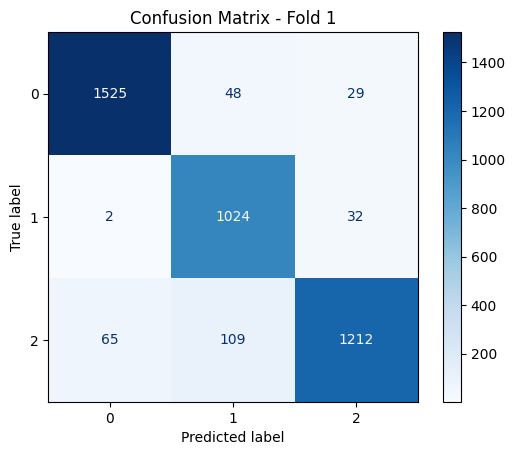

Fold 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 536.0260, Training Accuracy: 0.9009
Epoch 2, Loss: 439.6248, Training Accuracy: 0.9511
Epoch 3, Loss: 398.2655, Training Accuracy: 0.9703
Epoch 4, Loss: 383.3184, Training Accuracy: 0.9791
Epoch 5, Loss: 365.1938, Training Accuracy: 0.9858
Fold 2 Validation Accuracy: 0.9234


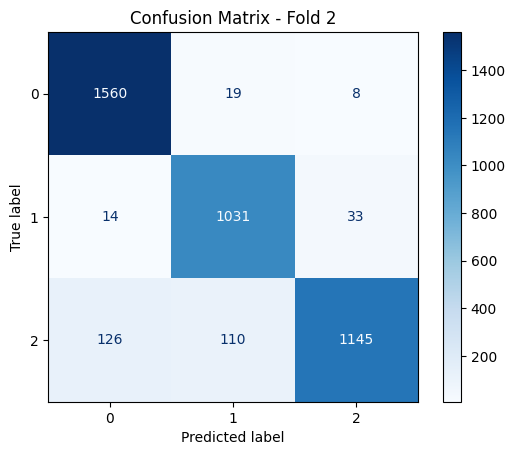

Fold 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 532.3606, Training Accuracy: 0.9000
Epoch 2, Loss: 433.5187, Training Accuracy: 0.9559
Epoch 3, Loss: 396.8733, Training Accuracy: 0.9708
Epoch 4, Loss: 379.8516, Training Accuracy: 0.9797
Epoch 5, Loss: 362.3307, Training Accuracy: 0.9878
Fold 3 Validation Accuracy: 0.9313


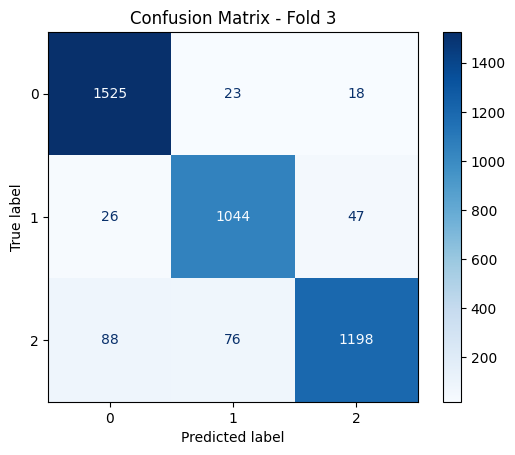

Fold 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 538.3571, Training Accuracy: 0.8980
Epoch 2, Loss: 435.8080, Training Accuracy: 0.9540
Epoch 3, Loss: 397.8574, Training Accuracy: 0.9713
Epoch 4, Loss: 372.3817, Training Accuracy: 0.9823
Epoch 5, Loss: 364.9366, Training Accuracy: 0.9857
Fold 4 Validation Accuracy: 0.9362


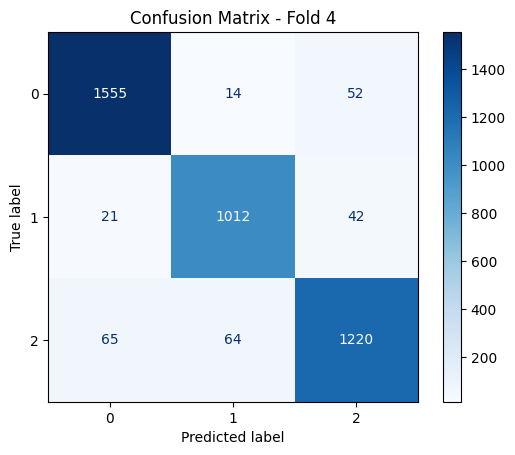

Fold 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 546.3361, Training Accuracy: 0.8930
Epoch 2, Loss: 442.7060, Training Accuracy: 0.9503
Epoch 3, Loss: 401.9990, Training Accuracy: 0.9712
Epoch 4, Loss: 381.9621, Training Accuracy: 0.9789
Epoch 5, Loss: 366.0997, Training Accuracy: 0.9864
Fold 5 Validation Accuracy: 0.9375


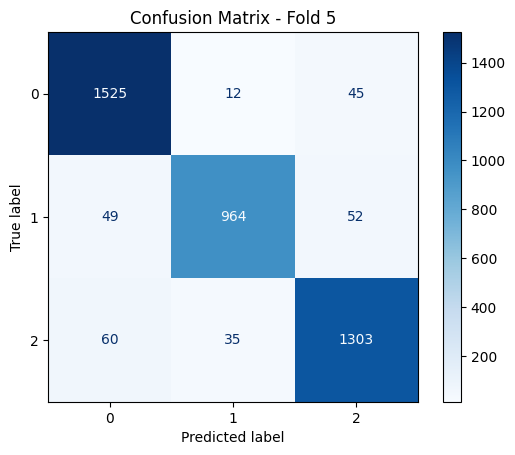

Models have been saved.
Cross-Validation Results: [0.9295600593178448, 0.9233811171527434, 0.9312731767614338, 0.9362175525339926, 0.9374536464771323]
Mean Accuracy: 0.9316


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load Dataset from CSV
df = pd.read_csv("/content/hopefully-fully-final.csv")  # Replace with your file path

# Ensure the CSV has columns: "cleaned_tweet" and "class"
df["cleaned_tweet"] = df["cleaned_tweet"].astype(str)  # Convert to string
df["cleaned_tweet"] = df["cleaned_tweet"].fillna("missing tweet")  # Handle missing values

texts = df["cleaned_tweet"].tolist()
labels = df["class"].tolist()

# Step 2: Compute Class Weights
class_counts = df["class"].value_counts().sort_index().tolist()  # Get counts for each class
classes = np.array(df["class"].unique())  # Convert to numpy array
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda")  # Match device

# Step 3: Define Dataset Class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),  # Remove batch dimension
            "attention_mask": inputs["attention_mask"].squeeze(0),  # Remove batch dimension
            "label": torch.tensor(label, dtype=torch.long)
        }

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Step 4: Define Models
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])  # Use the last hidden state for classification
        return out

# Step 5: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
dataset = CustomDataset(texts, labels, tokenizer)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}")

    # Subset the dataset for training and validation
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16)

    # Initialize models and optimizers for each fold
    bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(classes)).to("cuda")
    lstm_model = LSTMModel(
        vocab_size=tokenizer.vocab_size, embed_size=100, hidden_size=128, output_size=len(classes)
    ).to("cuda")

    optimizer_bert = AdamW(bert_model.parameters(), lr=5e-5)
    optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Training Loop
    bert_model.train()
    lstm_model.train()

    for epoch in range(5):  # Reduce epochs for faster demonstration
        total_loss = 0
        correct_train, total_train = 0, 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            # Forward pass for BERT
            bert_outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            bert_logits = bert_outputs.logits

            # Forward pass for LSTM
            lstm_outputs = lstm_model(input_ids)  # Use input_ids for LSTM

            # Compute loss for both models
            loss_bert = criterion(bert_logits, labels)
            loss_lstm = criterion(lstm_outputs, labels)

            # Combine the losses using weighted averaging
            loss = (0.7 * loss_bert + 0.3 * loss_lstm)

            # Backward pass and optimization
            optimizer_bert.zero_grad()
            optimizer_lstm.zero_grad()
            loss.backward()
            optimizer_bert.step()
            optimizer_lstm.step()

            total_loss += loss.item()

            # Calculate training accuracy
            ensemble_logits = 0.7 * bert_logits + 0.3 * lstm_outputs
            predictions = torch.argmax(ensemble_logits, dim=1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = correct_train / total_train
        print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation Loop
    bert_model.eval()
    lstm_model.eval()
    correct_val, total_val = 0, 0
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to("cuda")
            attention_mask = batch["attention_mask"].to("cuda")
            labels = batch["label"].to("cuda")

            # Ensemble Prediction
            bert_logits = bert_model(input_ids=input_ids, attention_mask=attention_mask).logits
            lstm_logits = lstm_model(input_ids)
            ensemble_logits = 0.7 * bert_logits + 0.3 * lstm_logits
            predictions = torch.argmax(ensemble_logits, dim=1)

            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    accuracy = correct_val / total_val
    print(f"Fold {fold + 1} Validation Accuracy: {accuracy:.4f}")
    fold_results.append(accuracy)

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=range(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(classes)))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

# Save Models
bert_model.save_pretrained("/content/drive/MyDrive/ML-shit/folds-5")
tokenizer.save_pretrained("/content/drive/MyDrive/ML-shit/folds-5")
torch.save(lstm_model.state_dict(), "/content/drive/MyDrive/ML-shit/folds-5/lstm_model.pth")

print("Models have been saved.")

# Final Results
print(f"Cross-Validation Results: {fold_results}")
print(f"Mean Accuracy: {np.mean(fold_results):.4f}")
